# Brute-force detection of a time step

Imagine a timeseries that consists of 2 plateaux connected by a short down ramp.

The frequency distribution of such a timeseries will have 2 humps: one centered on the values of the first plateau level, the other centred on those of the second plateau.

We can measure how well a timeseries $S$ fits this model, i.e. to what extent is has a bimodal frequency distribution, by:

- considering it as two subseries $S = [A, B]$ split at an arbitrary point
- computing the difference between the standard deviations $\sigma(S)-\sigma(A)-\sigma(B)$
- maximising this difference over all possible bisections

In addition, to find series that step down rather than up we can stipulate that $E(A)>E(B)$

I've executed this below for the "total items" timeseries at the BNF chemical level.

In [2]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq,practice # my local stuff
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


# Get the data from ebmdatalab project in BigQuery

See comments in gbq.py for how to configure using gcloud command line tool.

In [38]:
df=gbq.query(
    '''
    select TIMESTAMP_TO_MSEC(month) PERIOD,left(bnf_code,11) BNF_CHEMICAL,sum(actual_cost) TOTAL_ACT_COST,sum(items) TOTAL_ITEMS
    from [hscic.prescribing]
    group by PERIOD,BNF_CHEMICAL
    ''',
    max_rows=1000000,index=['BNF_CHEMICAL','PERIOD'],
    cast={'TOTAL_ACT_COST':float,'TOTAL_ITEMS':float,'PERIOD':lambda t:datetime.fromtimestamp(int(t)/1000)},
    cachedir='/var/gbq',dirty=False
)

Big Query returned in 109.47 seconds
Waiting on bqjob_r771325a8406d74b6_000001527086ed59_1 ... (0s) Current status: DONE   
794790 rows converted to DataFrame in 5.03 seconds


In [55]:
df.head()

TOTAL_ACT_COST  TOTAL_ITEMS
BNF_CHEMICAL PERIOD                                          
0401010T0AA  2013-09-01 01:00:00      3685562.70       155365
0407020A0BF  2014-11-01 00:00:00        72758.24         2615
23601006331  2015-03-01 00:00:00       272304.18         2143
0407020Q0BC  2011-05-01 01:00:00       238904.69        46795
23605606274  2014-07-01 01:00:00         1486.66           11

# Apply the scoring and plot the highest scoring chemicals

I'm looking for steps in TOTAL_ITEMS - plotted in green. I also include TOTAL_ACT_COST - in blue with its scale on the right - in case it's useful.

Since we aleady evaluated some of these chemicals in the previous notebook, I'll use different colours in their plots (magenta and cyan).

In [40]:
seen='''0205052V0 Valsartan
0406000J0 Domperidone
1003020R0 Piroxicam
1201010G0 Hydrocortisone Acetate
0202040B0 Co-Amilofruse (Amiloride HCl/Frusemide)
1304000H0 Clobetasone Butyrate
1201010Q0 Hydrocortisone
0904010U0 Gluten Free/Wheat Free Bread
1201010F0 Flumetasone Pivalate
1003020M0 Felbinac
1003020T0 Nicotinates
0212000AB Omega-3-Acid Ethyl Esters
1001010C0 Diclofenac Sodium
0103030S0 Sucralfate
0401010T0 Temazepam
0906011D0 Vitamin A
040101000 Other Hypnotic Preps
210200002 Catheters
200306005 Wound Management & other Dressings
1001010N0 Mefenamic Acid
1108010Q0 Polyvinyl Alcohol
0206040AE Naftidrofuryl Oxalate
238006080 Skin Fillers And Protectives
1310011M0 Mupirocin
0904010AA Gluten Free/Wheat Free Mixes
190201000 Other Individually Form Bought In Preps
0401020E0 Chlordiazepoxide Hydrochloride
0410020B0 Nicotine Dependence
1203040G0 Hexetidine
020400040 Co-Tenidone (Atenolol/Chlortalidone)
1001022G0 Hydrocortisone Acetate
0205051K0 Lisinopril with Diuretic
200900005 Stockinette
0209000L0 Dipyridamole
0407041F0 Ergotamine Tartrate
1202010P0 Sodium Cromoglicate
0212000V0 Omega-3 Marine Triglycerides
0501030F0 Demeclocycline Hydrochloride
1108010N0 Paraffin Yellow Soft
0604011H0 Estradiol, Estriol and Estrone'''.split('\n')
seen=set(x.partition(' ')[0] for x in seen)

In [72]:
def score(x):
    if len(x)>12:
        try:
            ps=[p for p in range(3,len(x)-2) if np.mean(x[:p])>np.mean(x[p:])]
            if ps:
                sd=np.std(x)
                return max([sd-np.std(x[:p])-np.std(x[p:]) for p in ps])
        except Exception, e:
            print e
    else:
        return -1

In [ ]:
#NB must sort index of df, as the score function assumes values are organised in time order (groupby preserves the order)
scores=df.sort().groupby(level=0).agg(score)

## Top 100

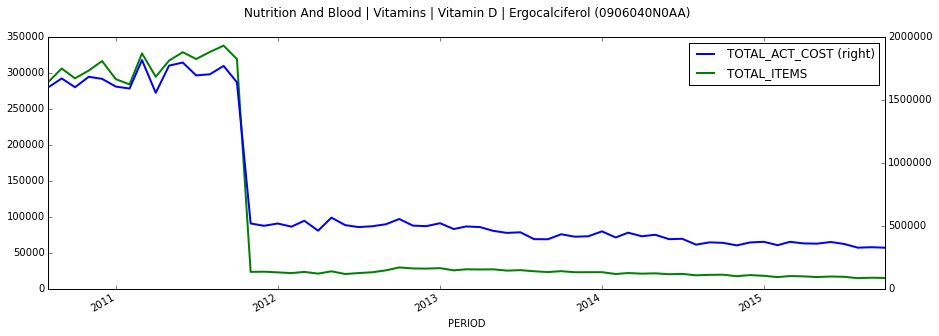

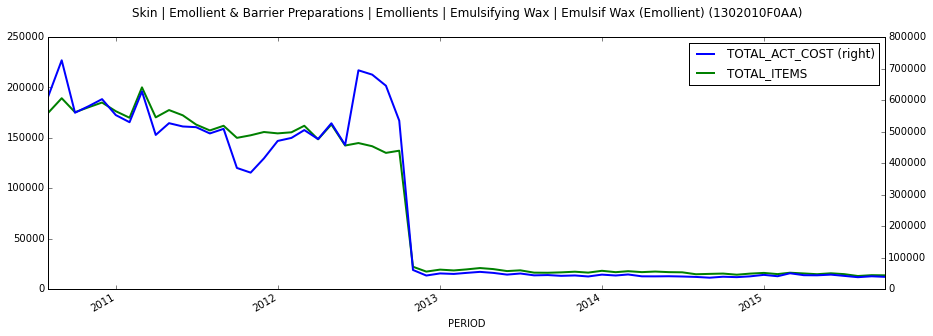

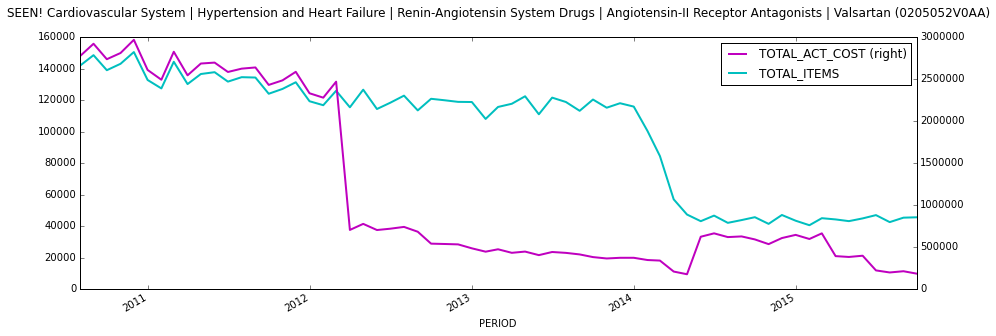

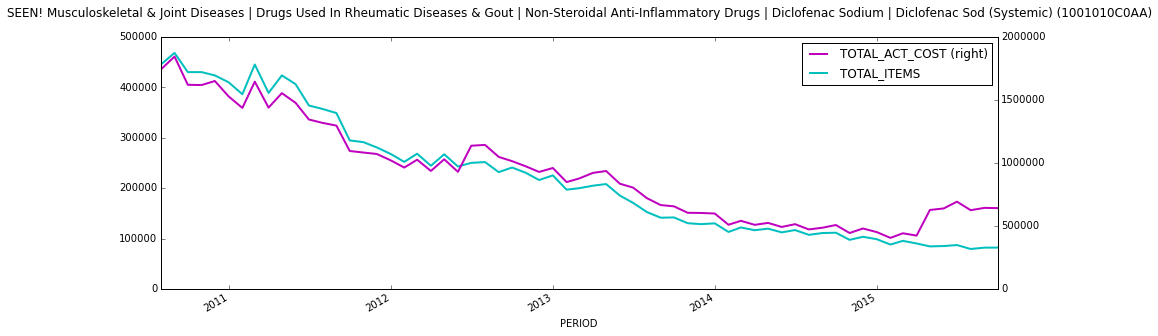

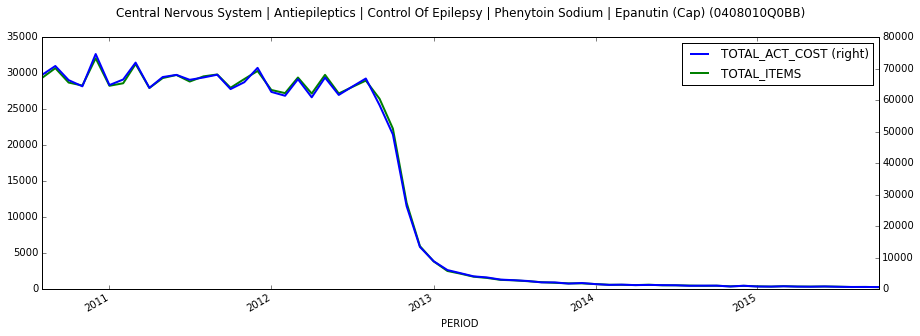

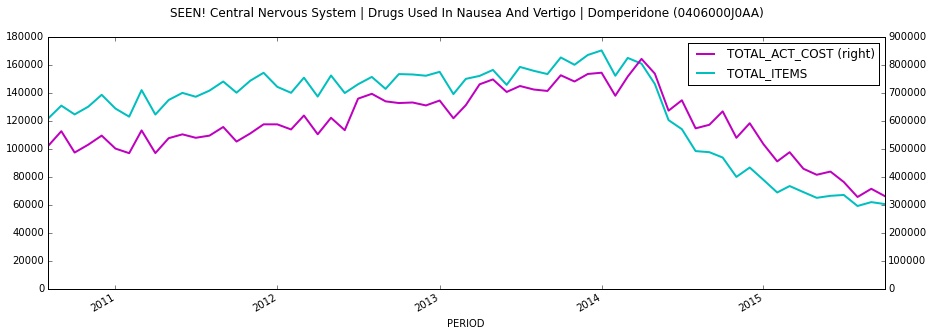

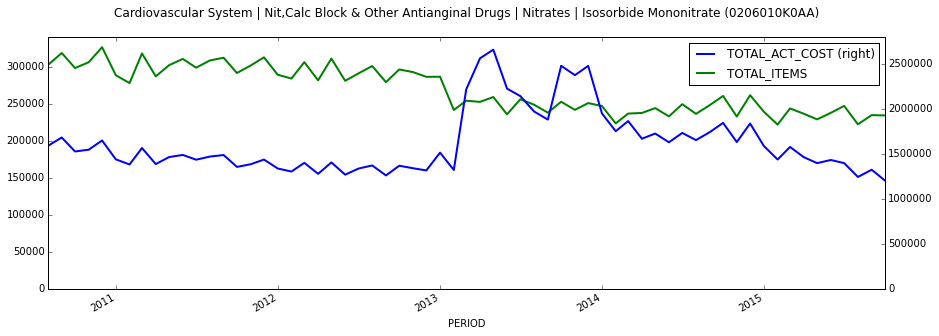

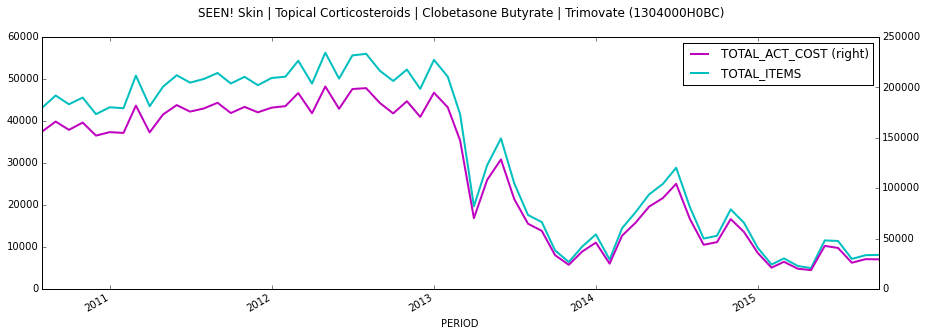

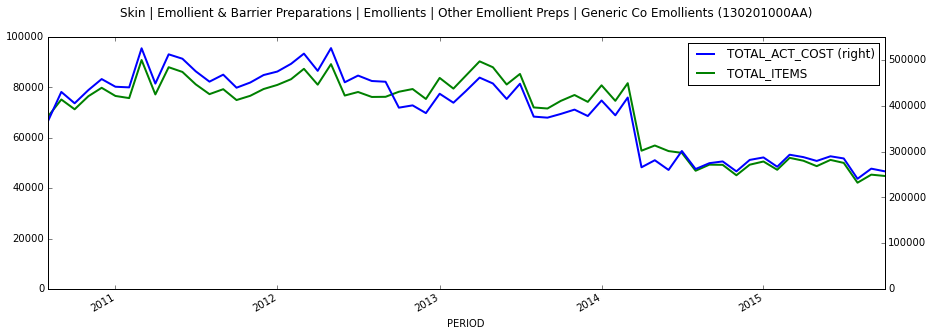

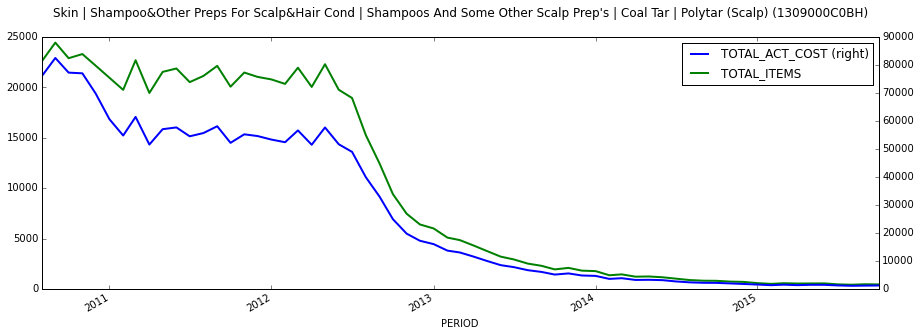

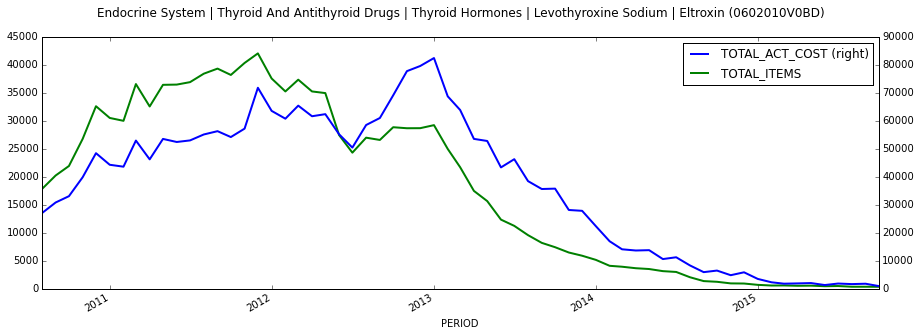

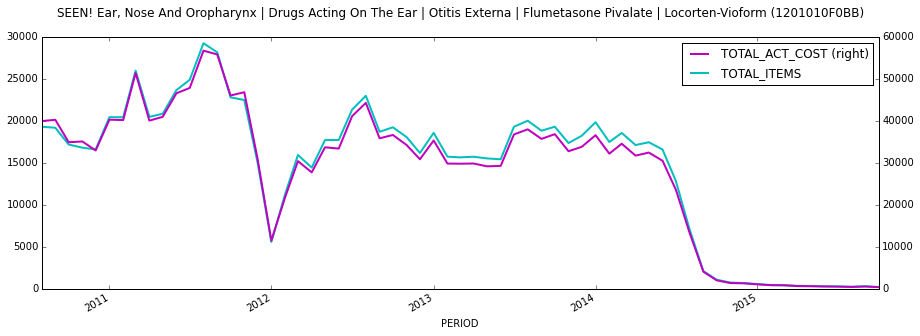

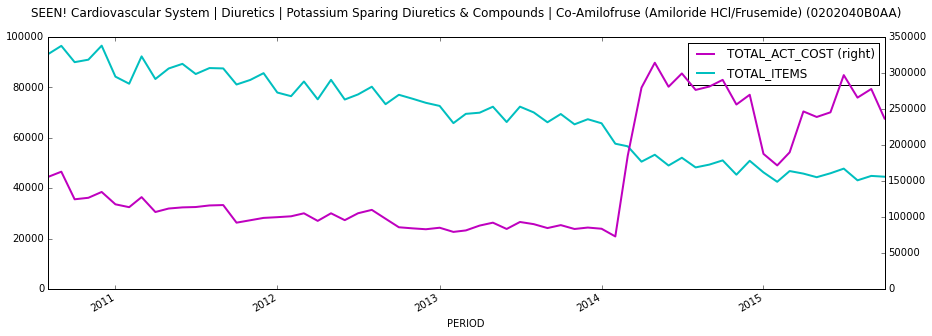

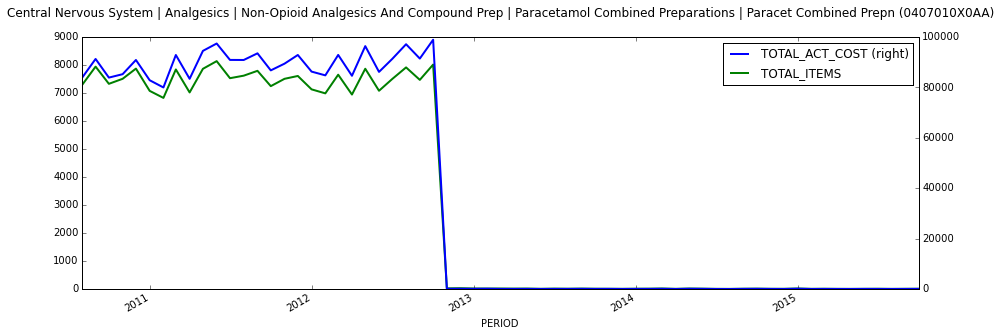

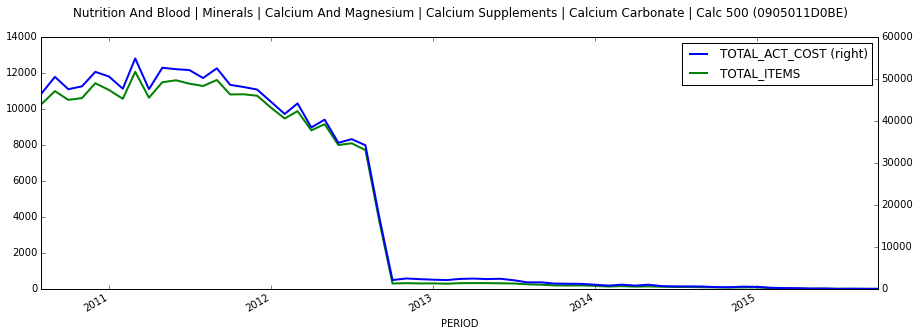

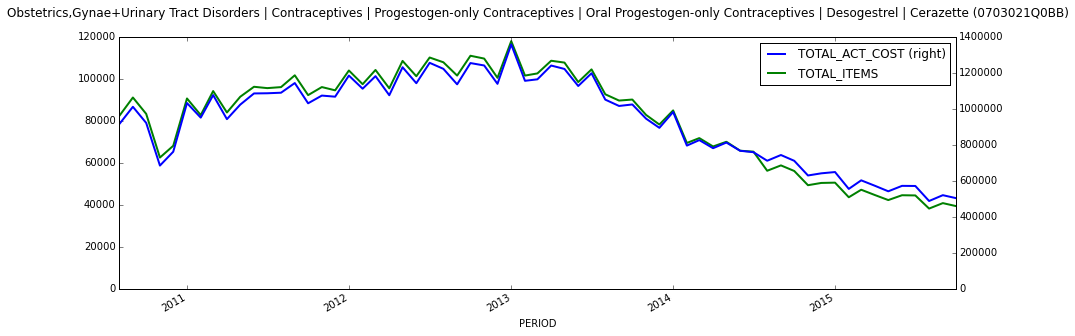

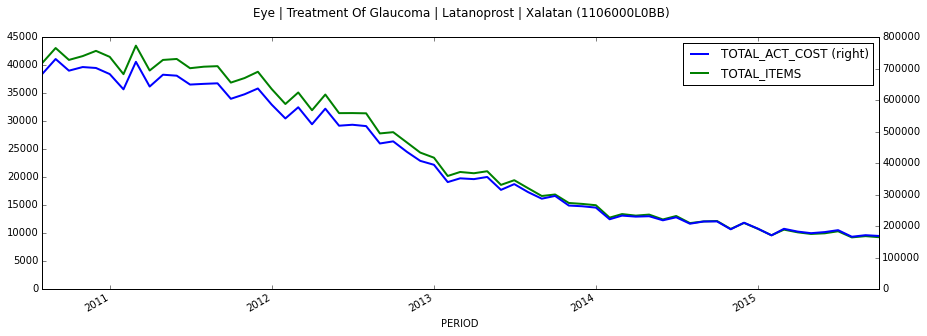

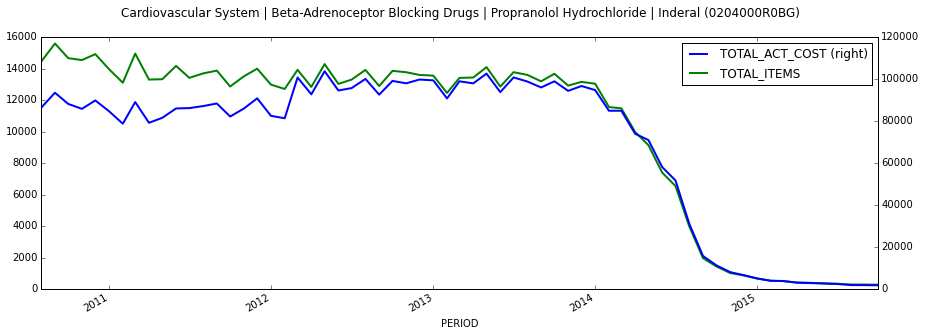

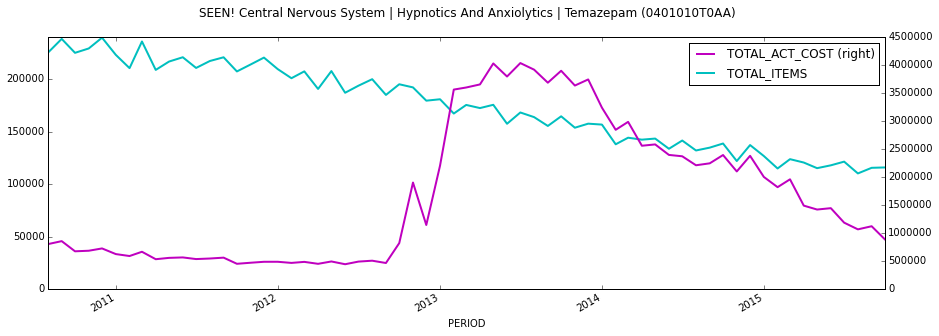

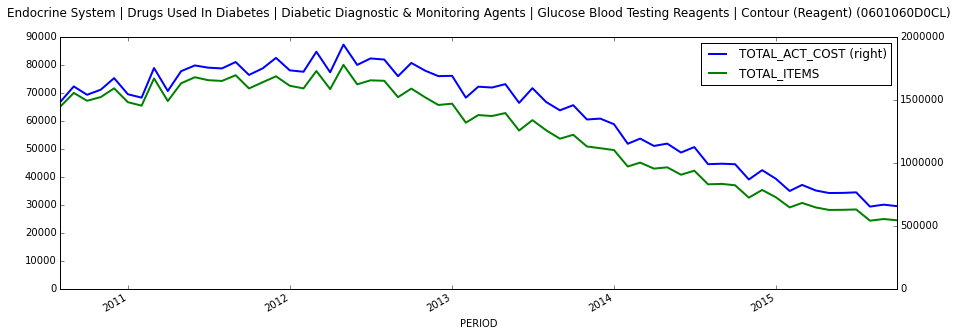

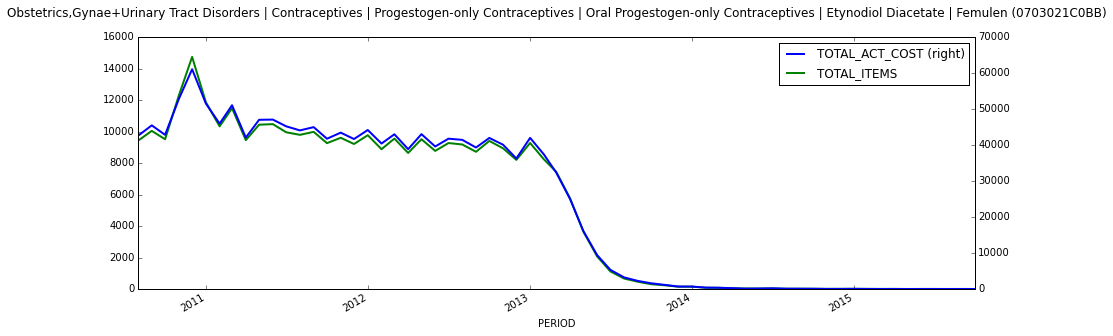

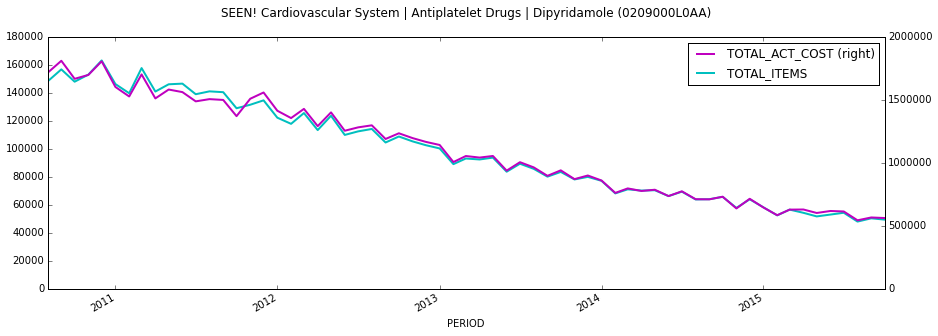

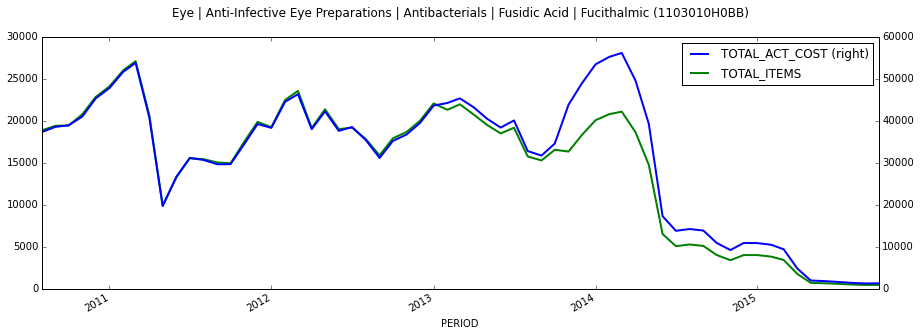

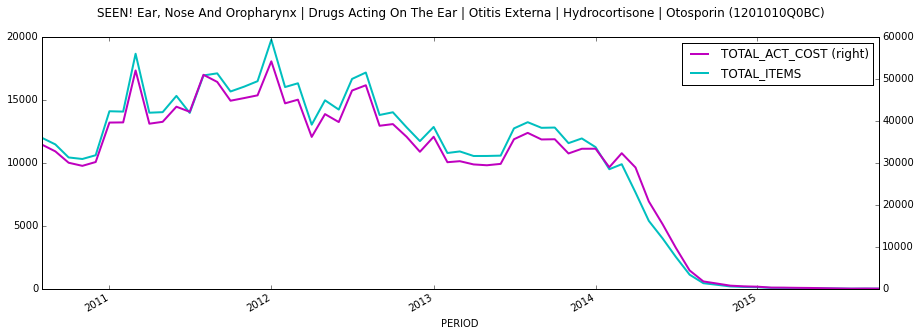

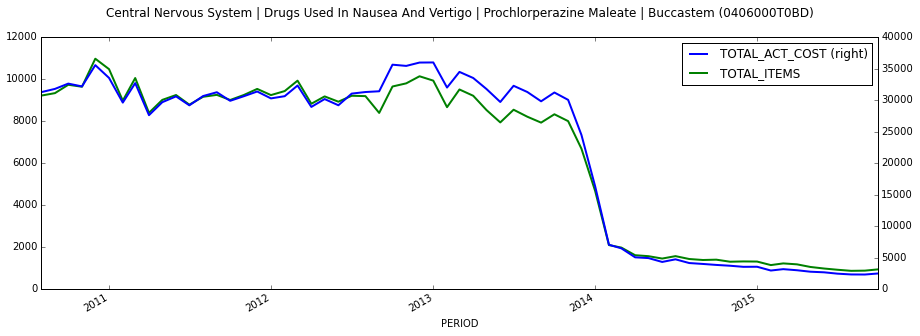

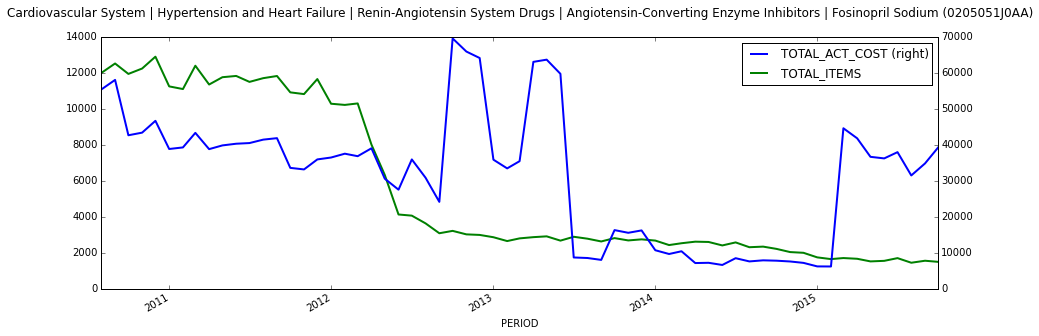

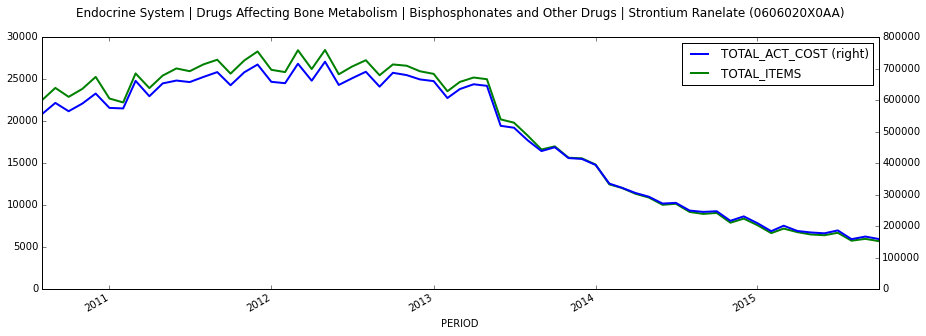

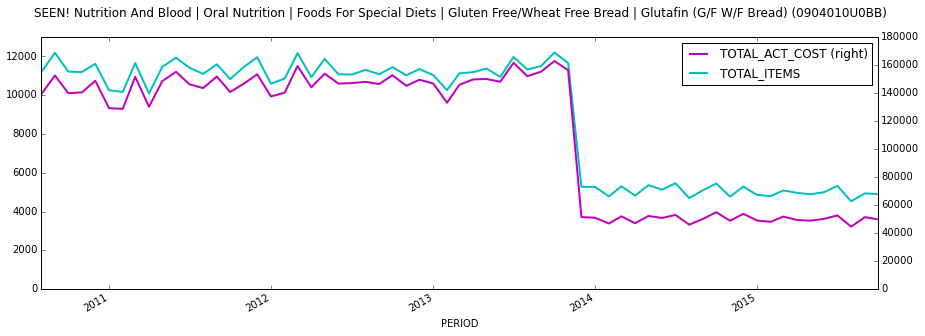

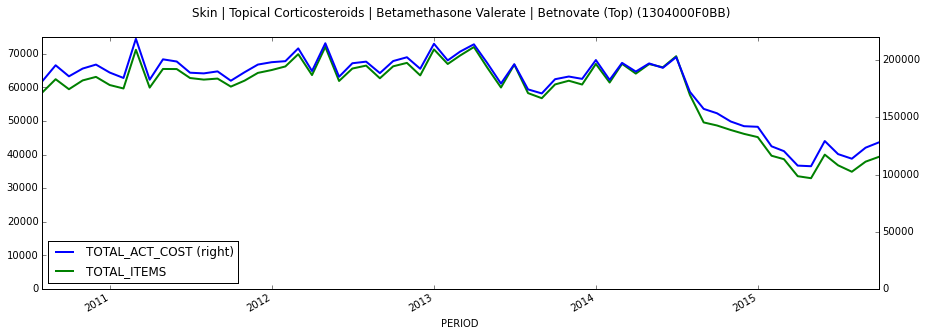

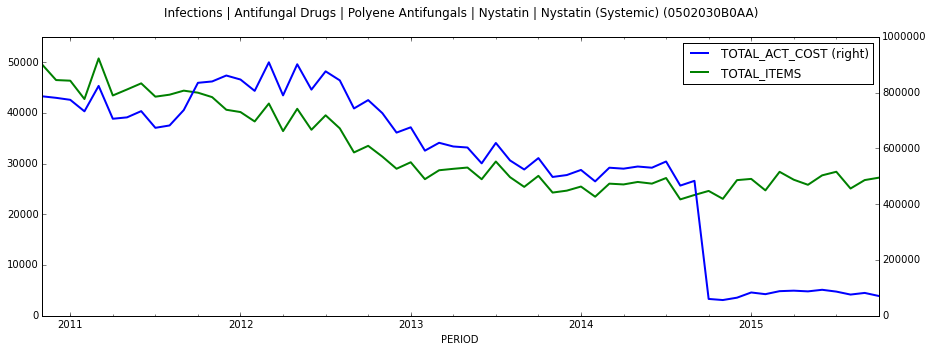

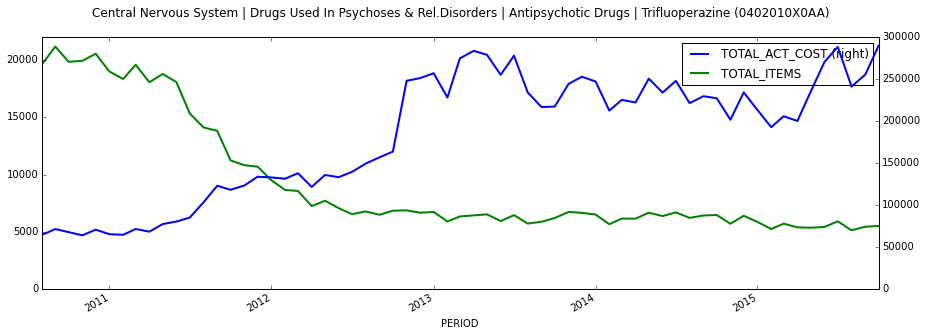

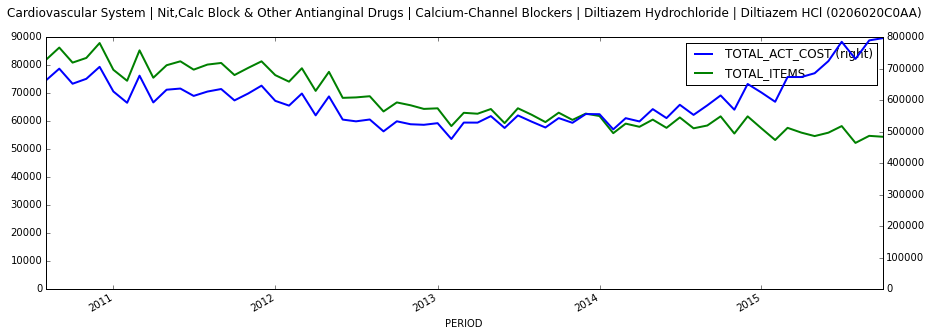

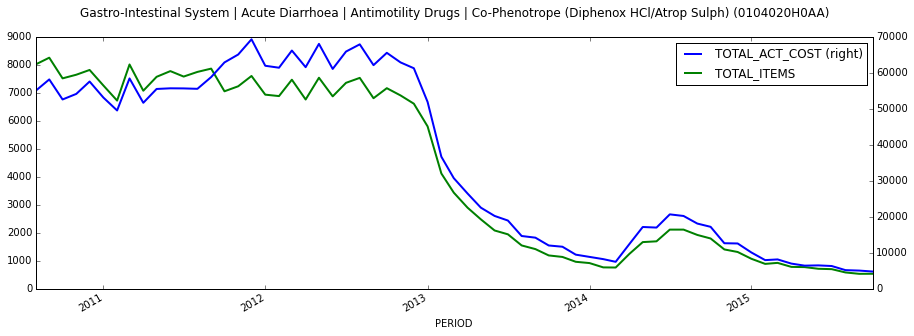

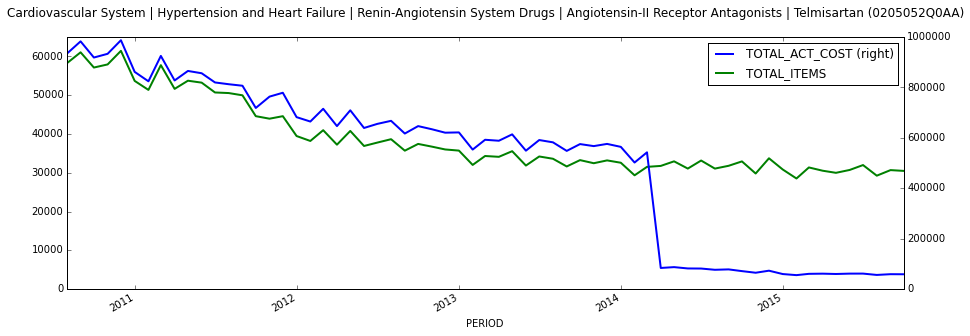

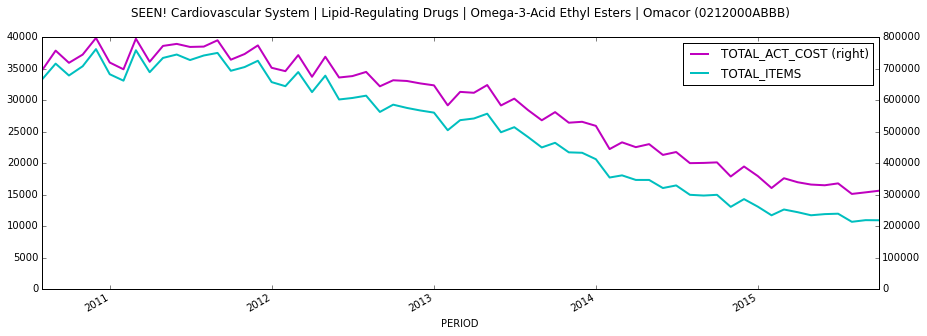

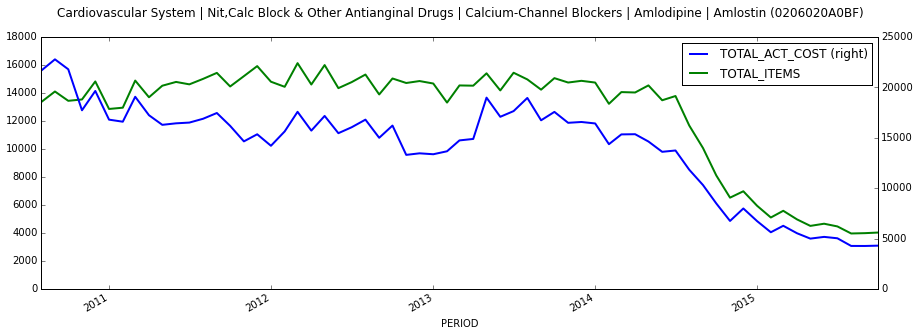

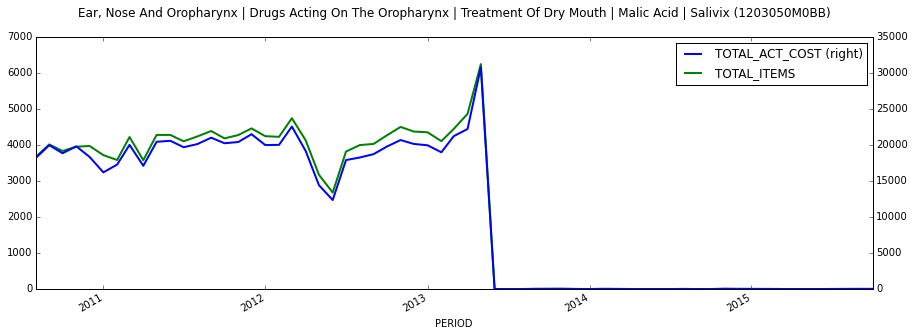

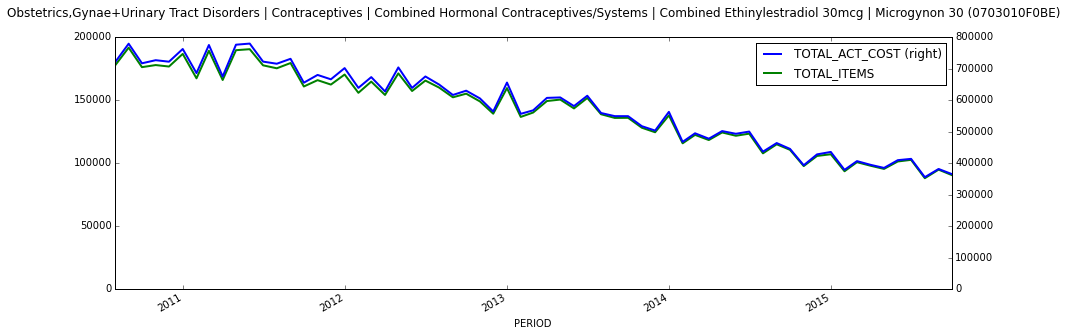

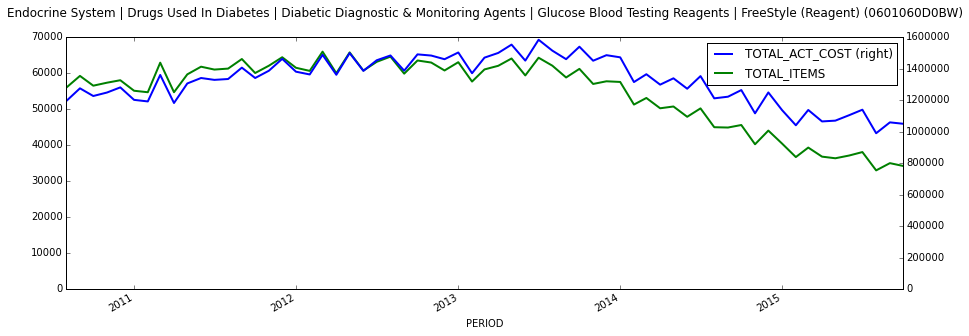

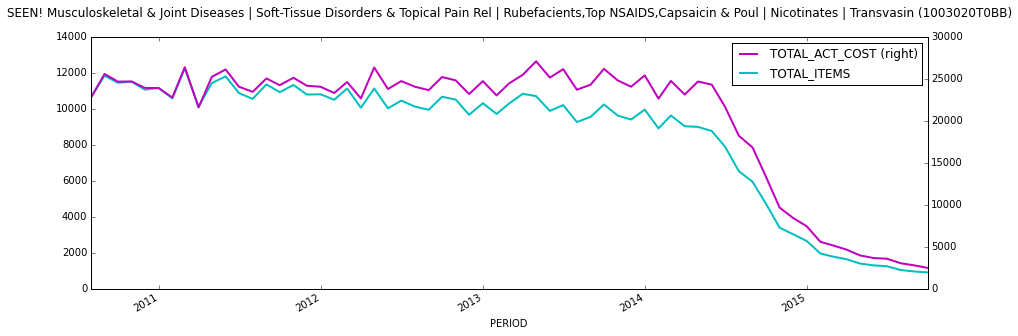

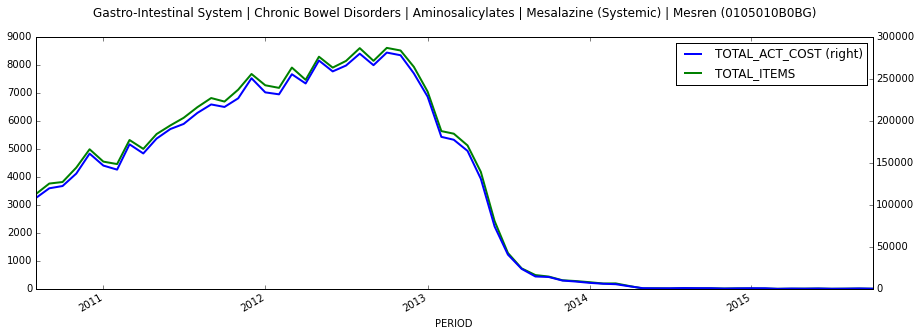

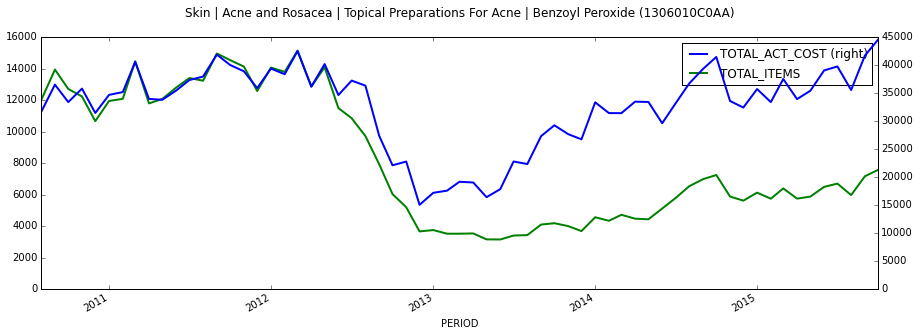

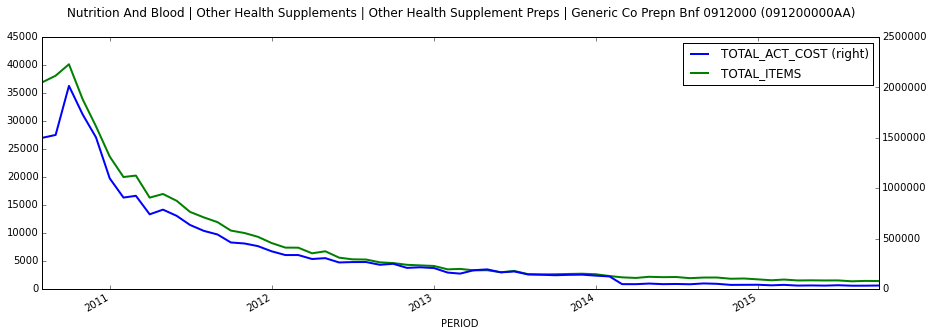

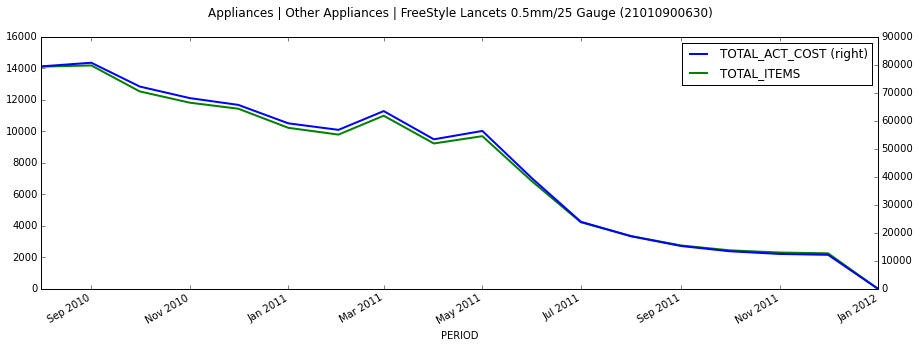

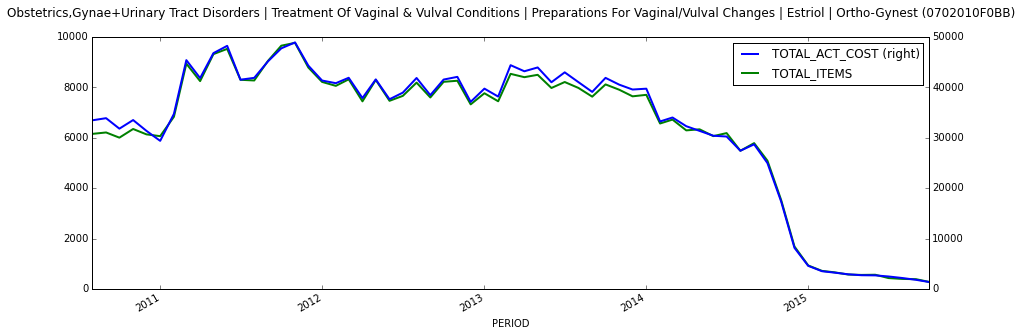

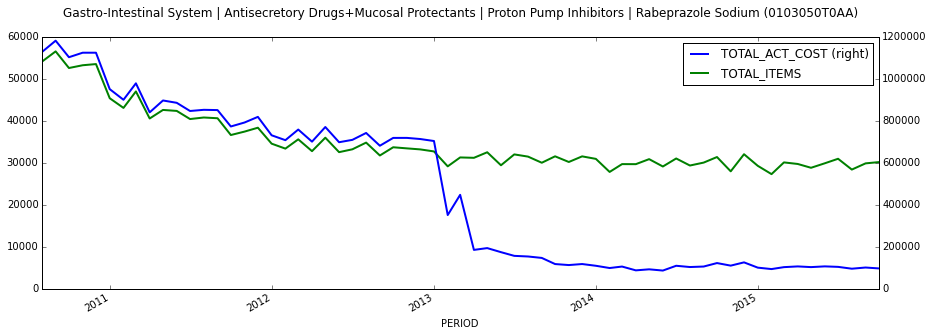

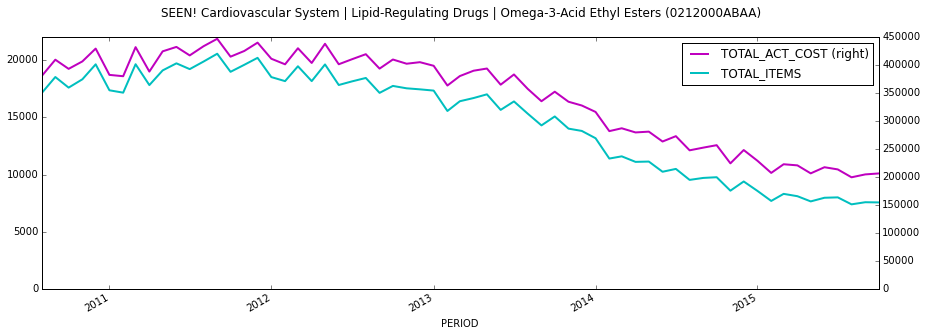

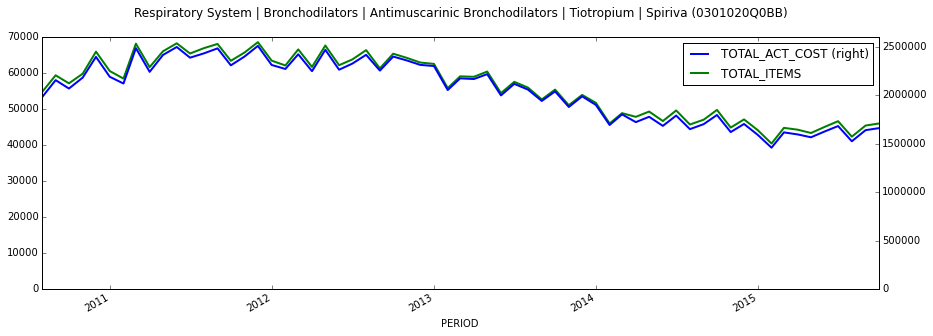

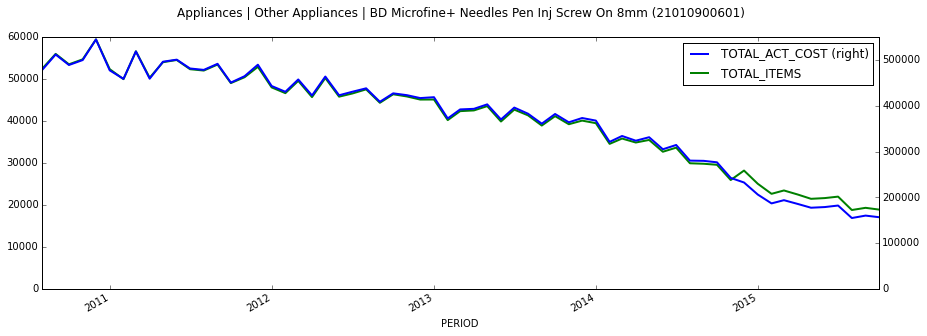

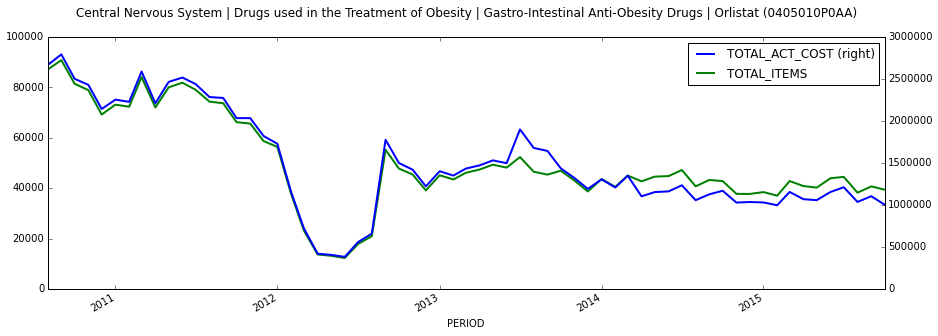

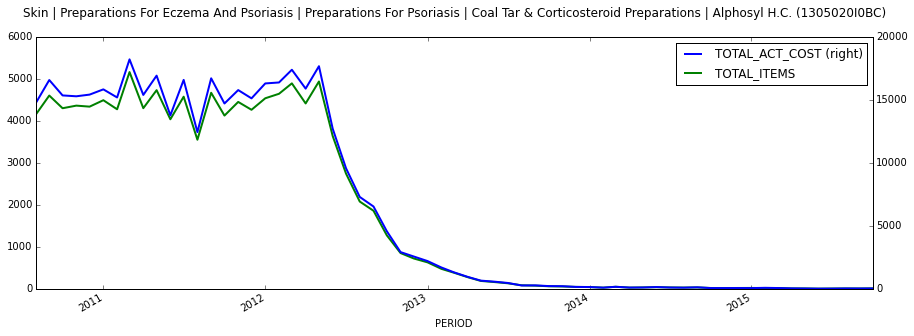

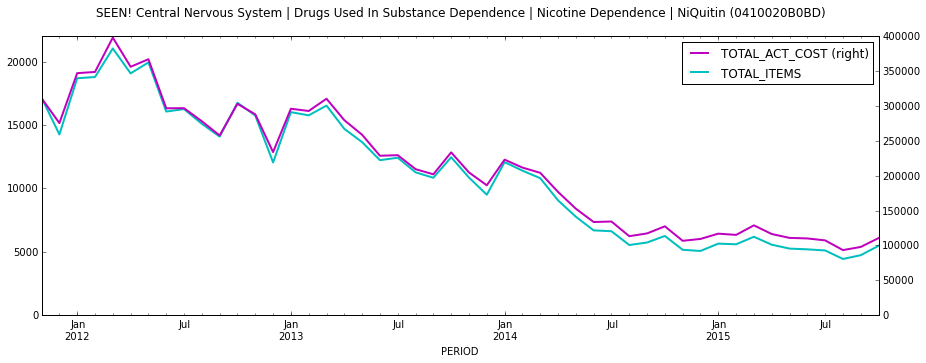

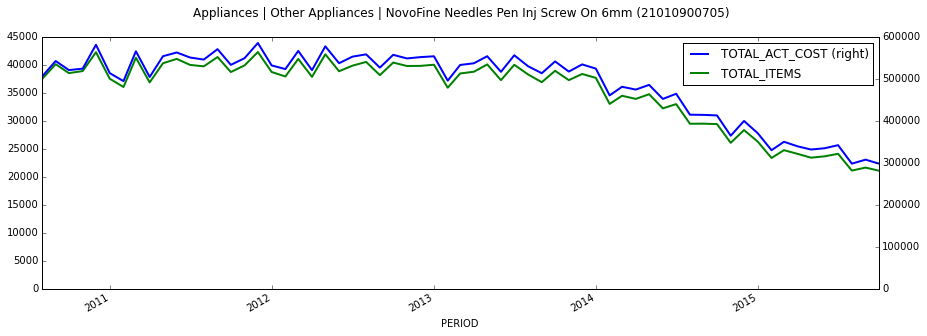

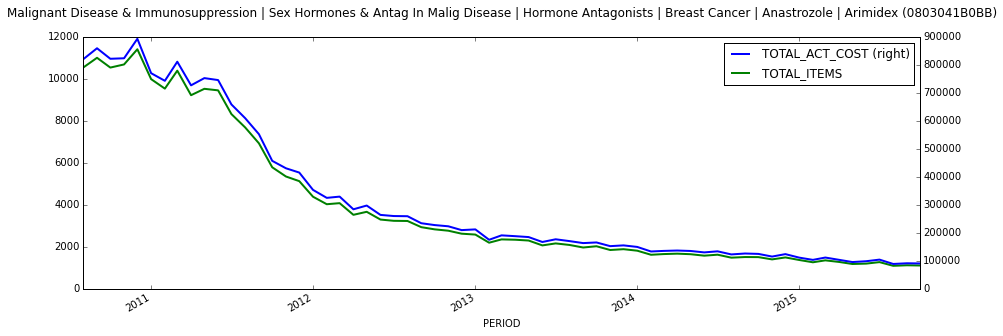

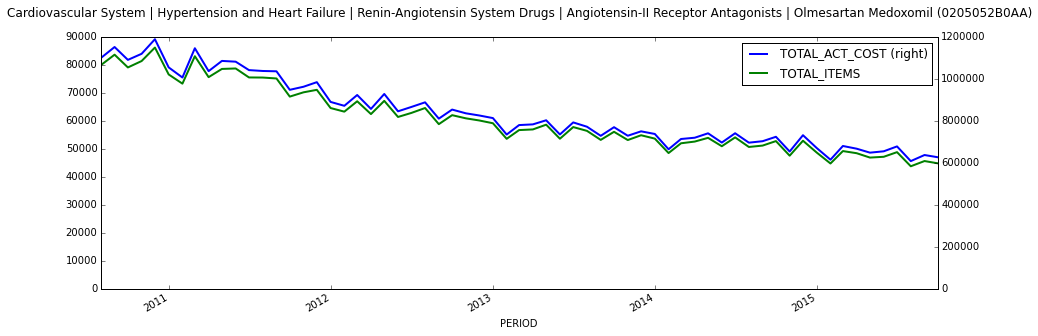

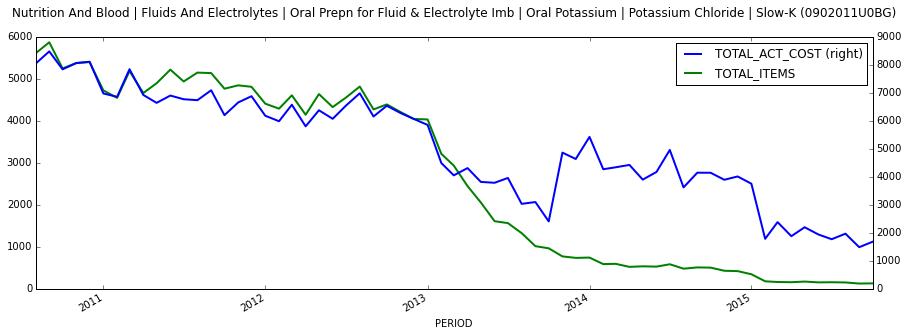

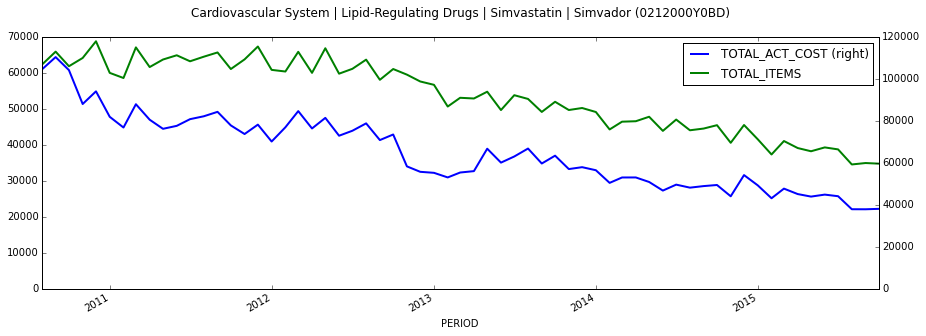

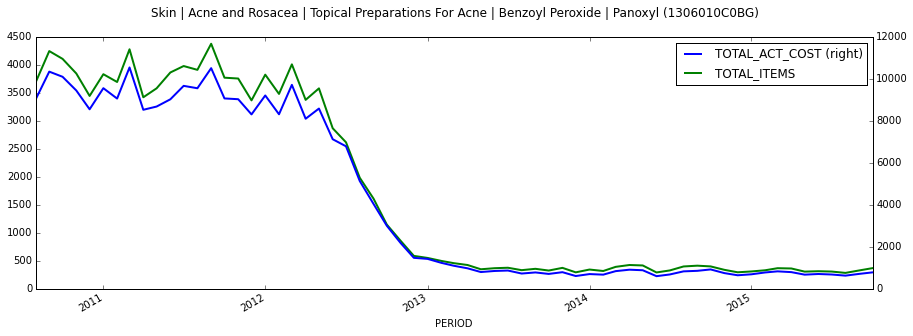

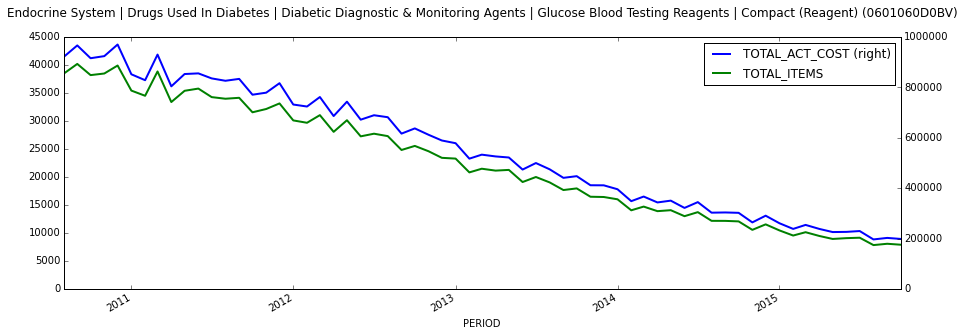

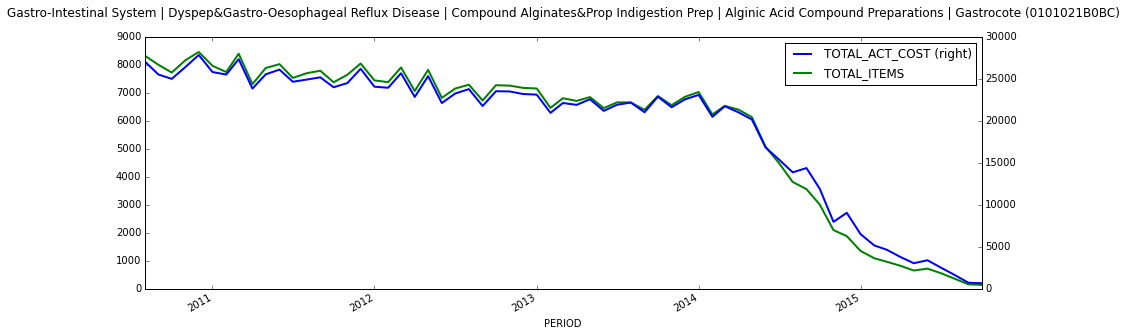

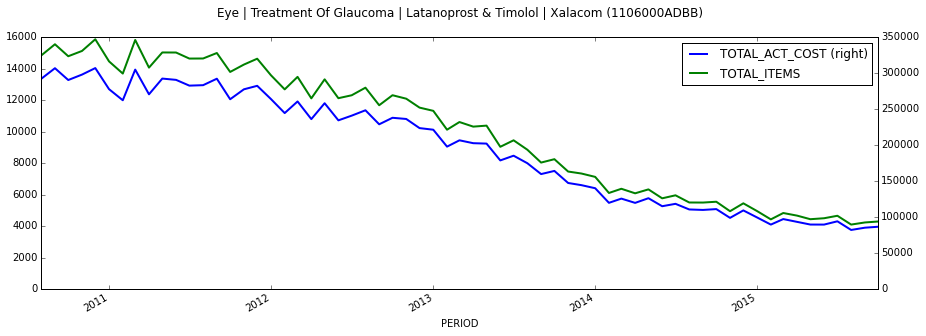

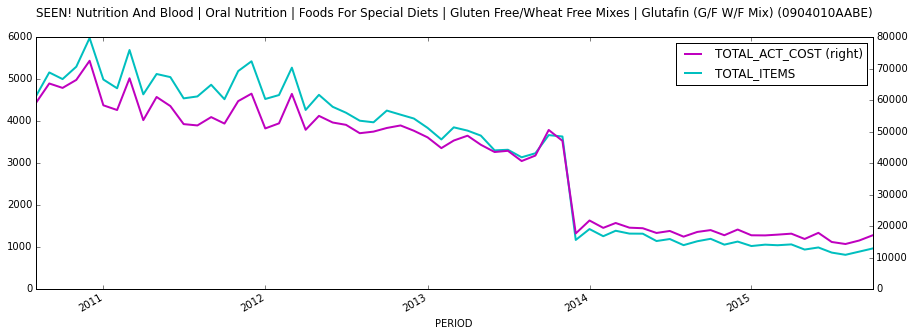

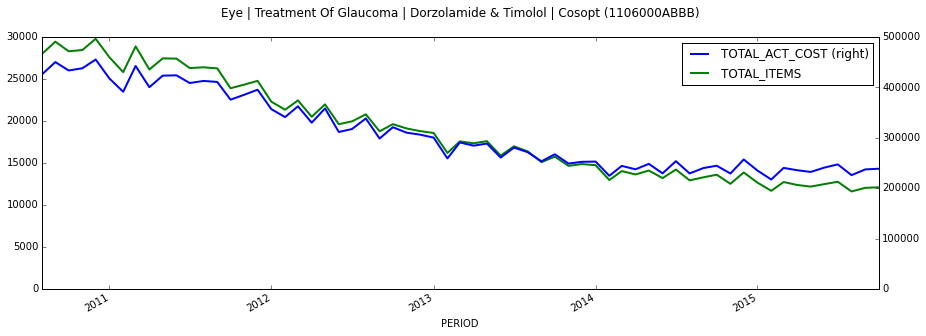

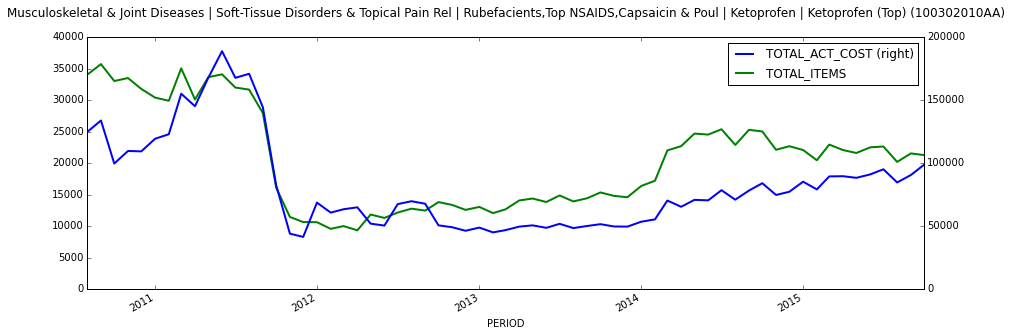

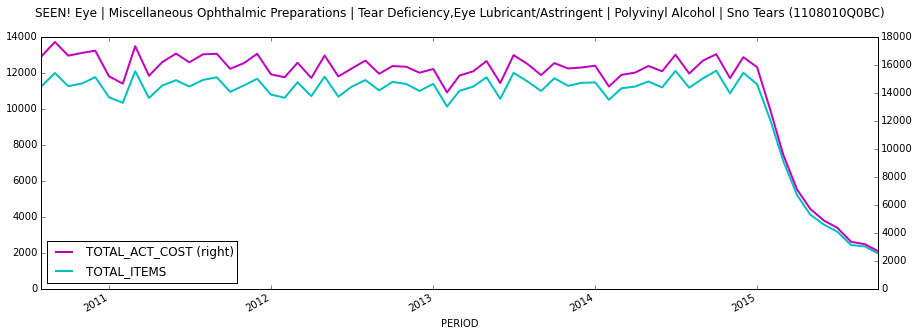

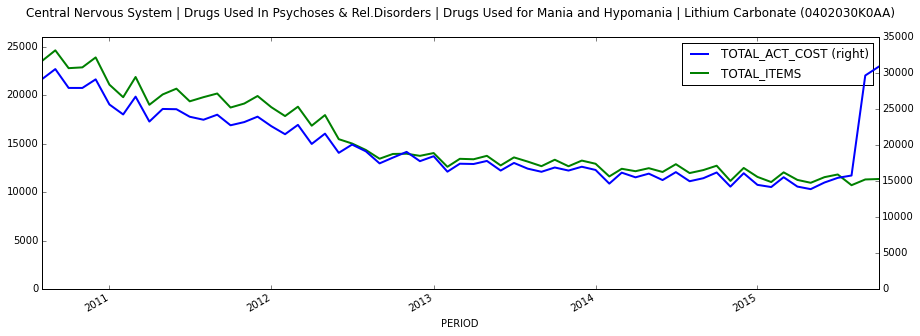

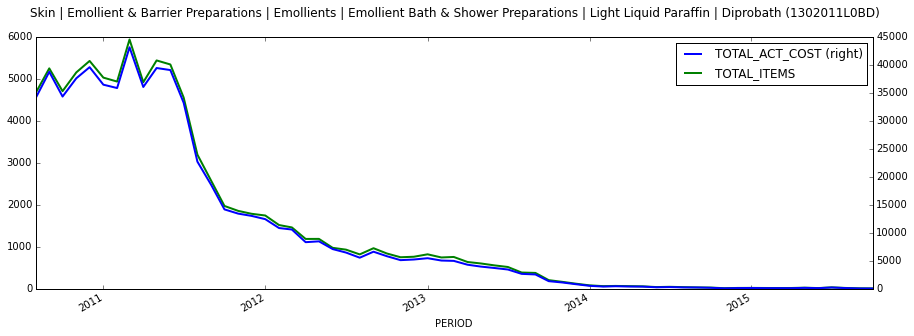

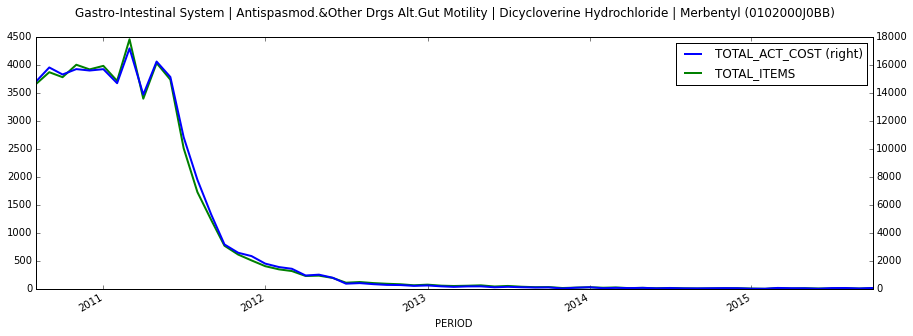

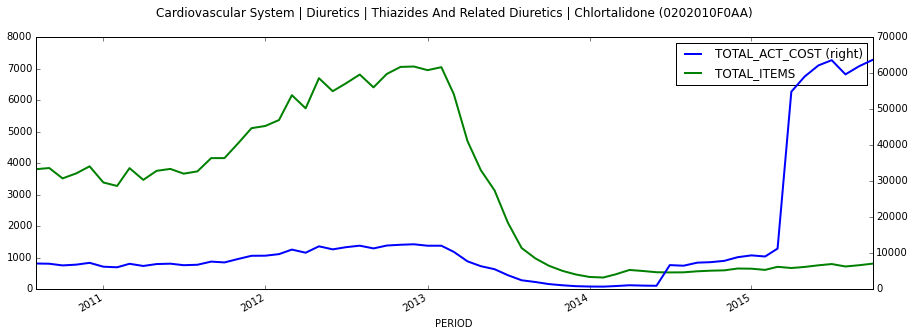

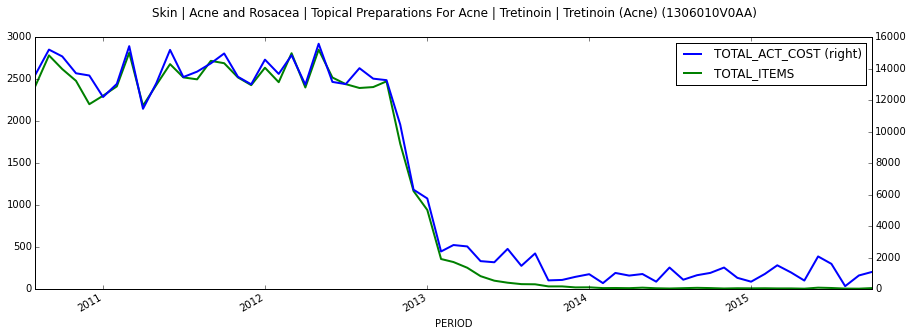

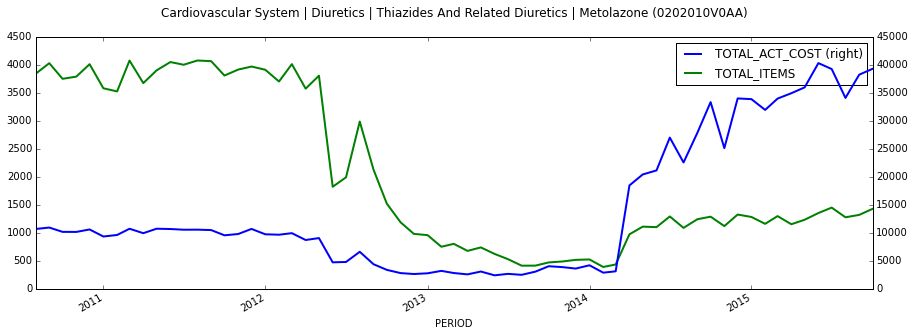

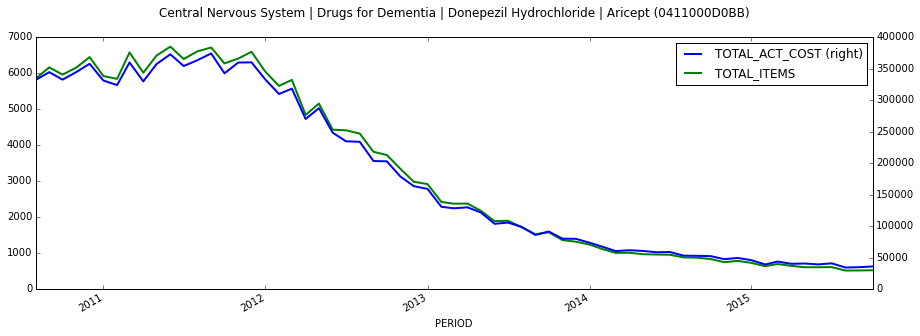

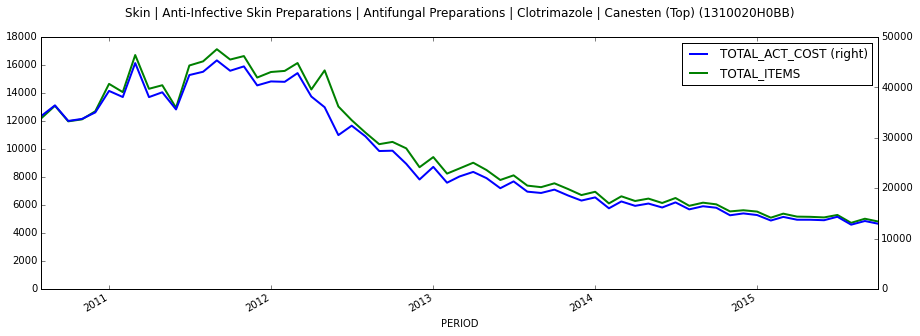

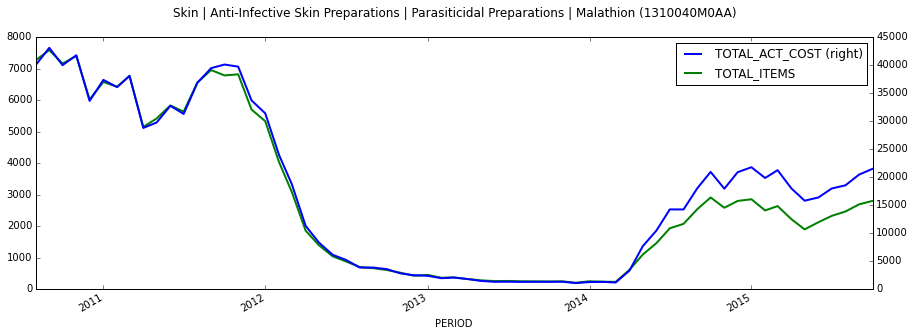

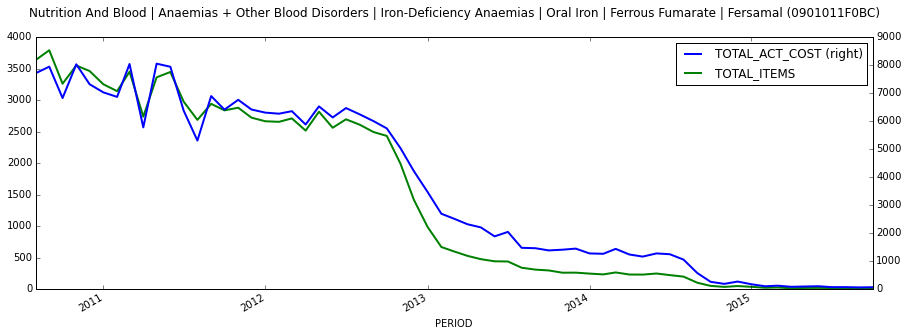

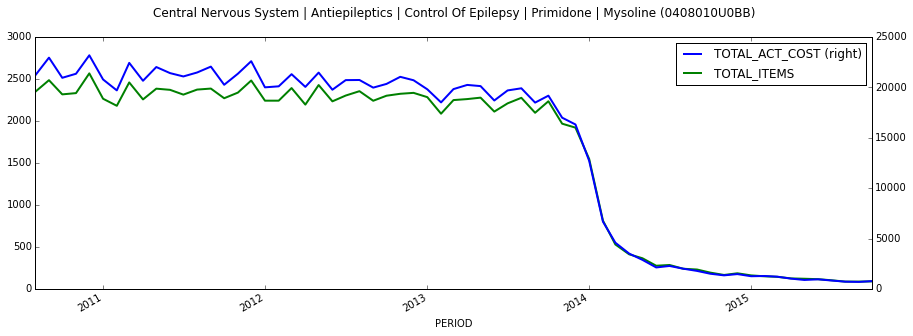

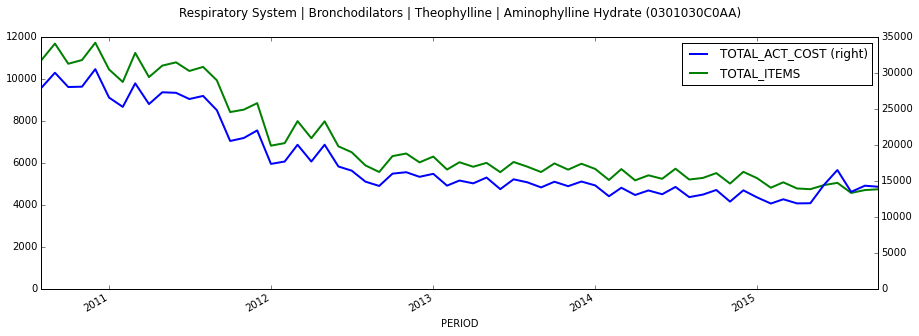

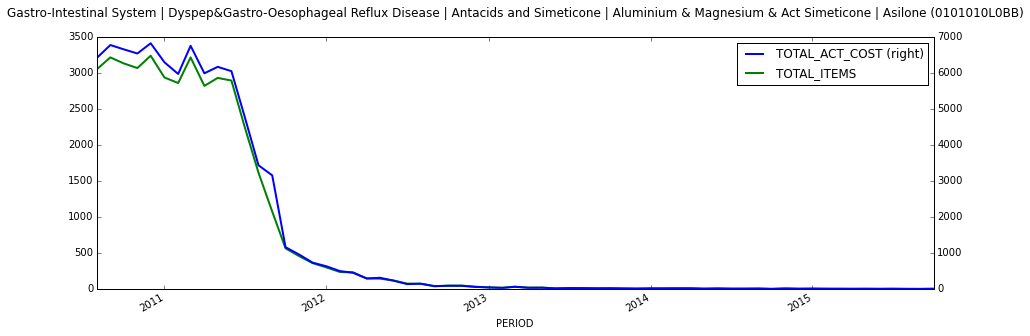

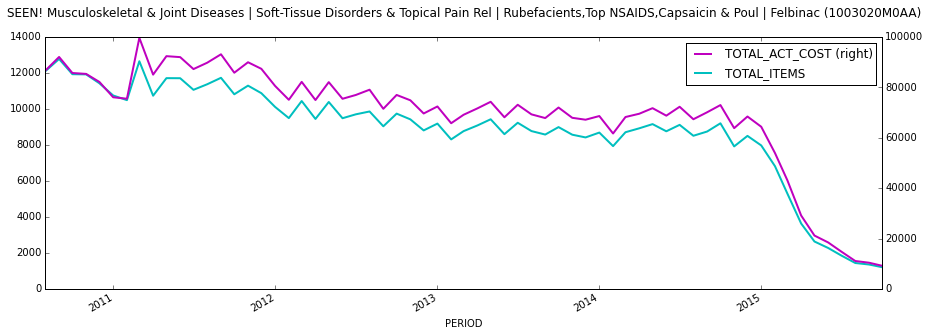

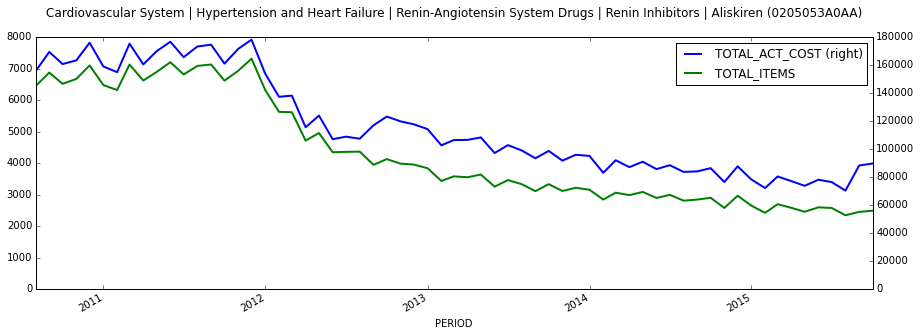

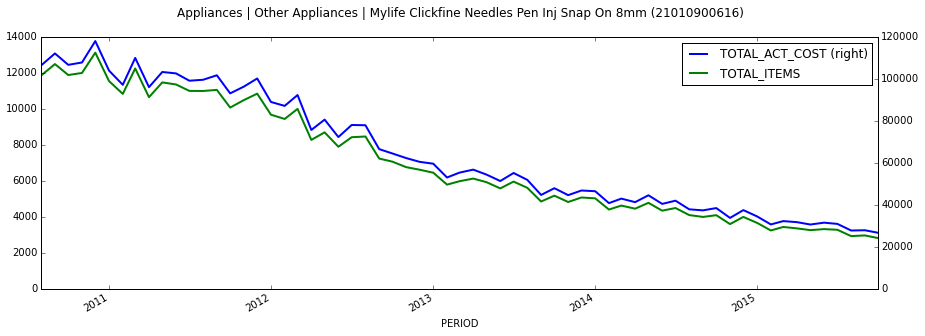

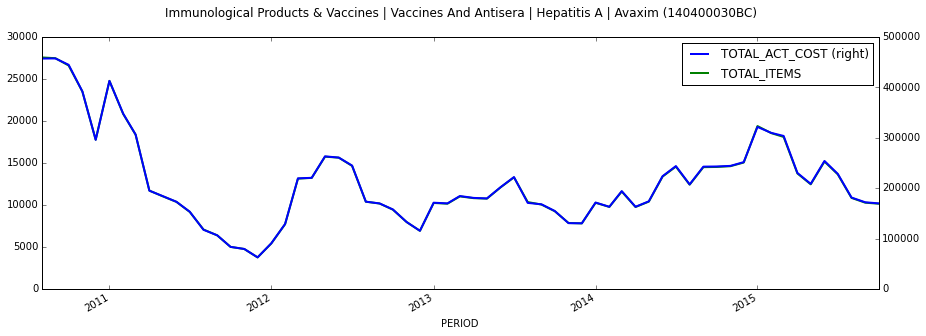

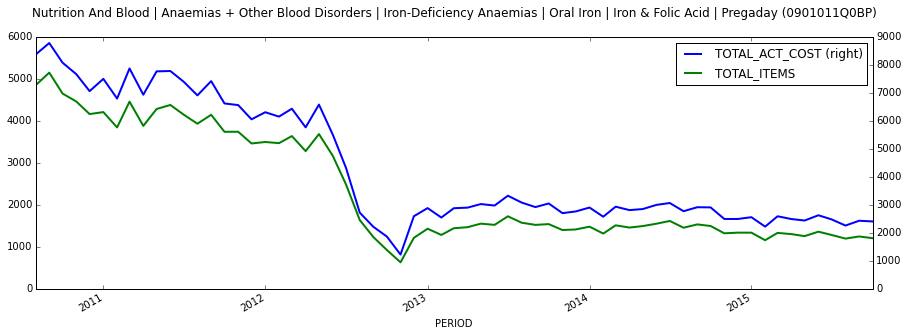

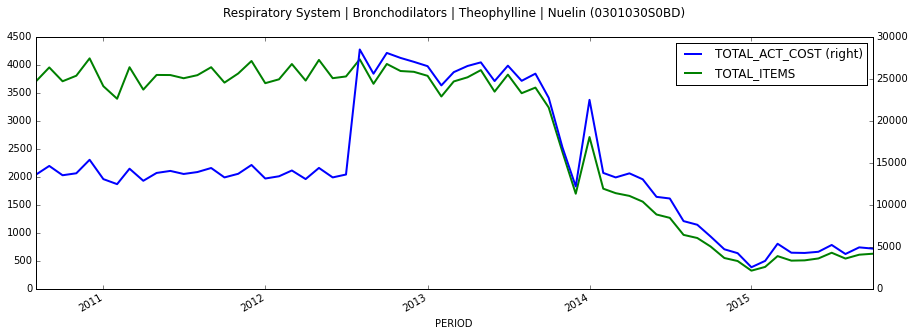

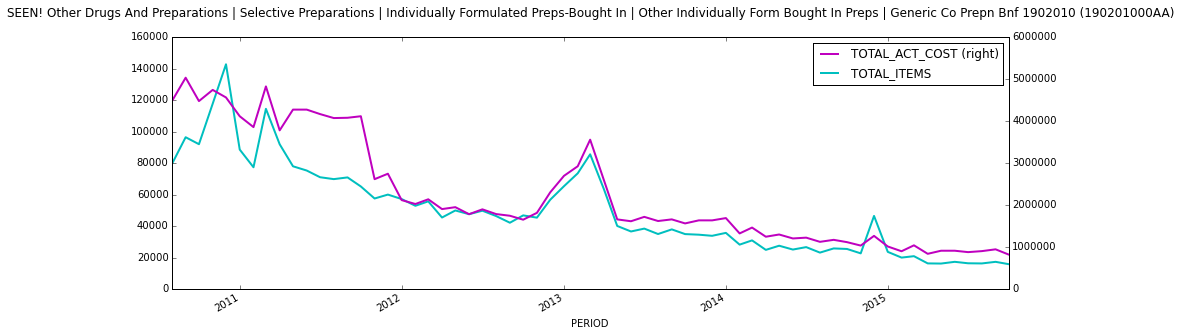

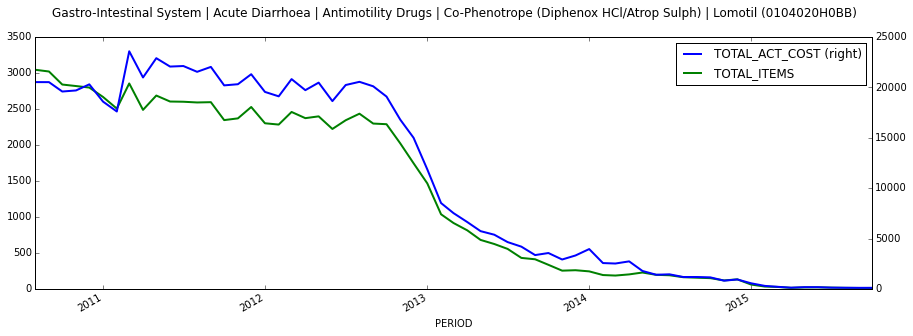

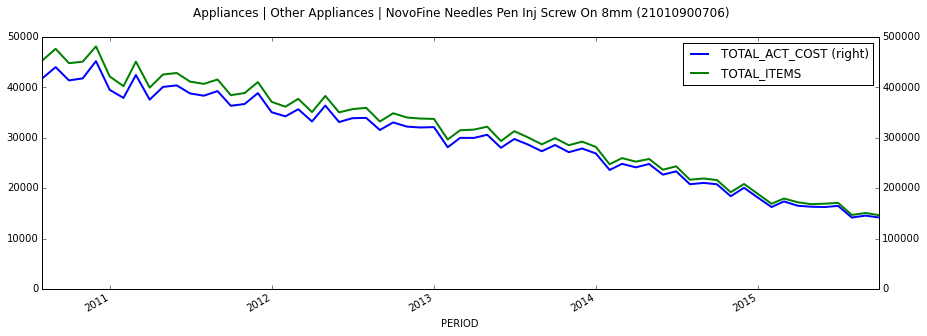

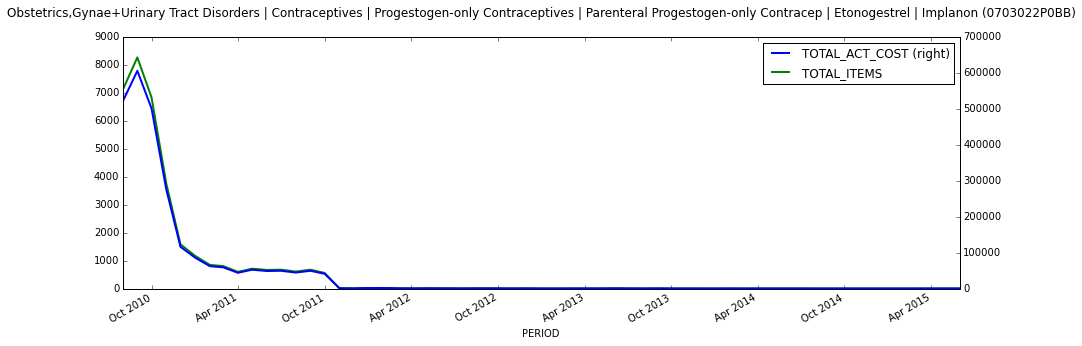

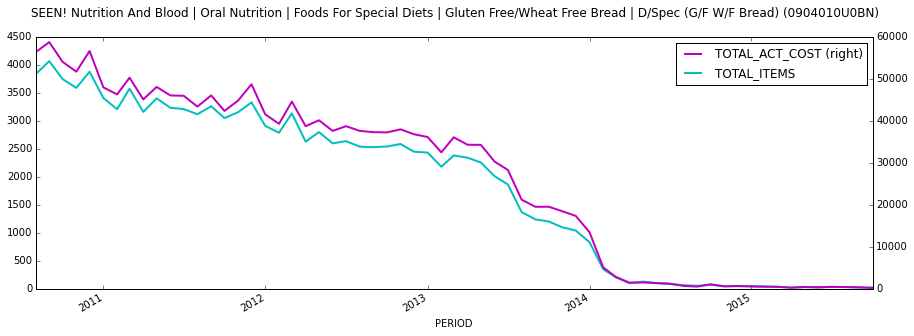

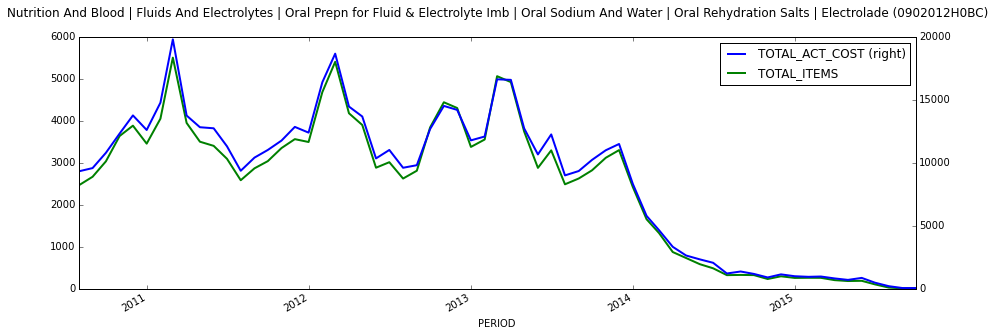

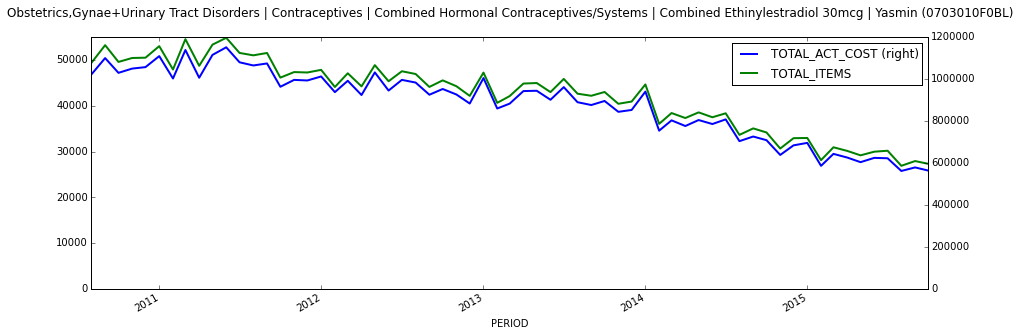

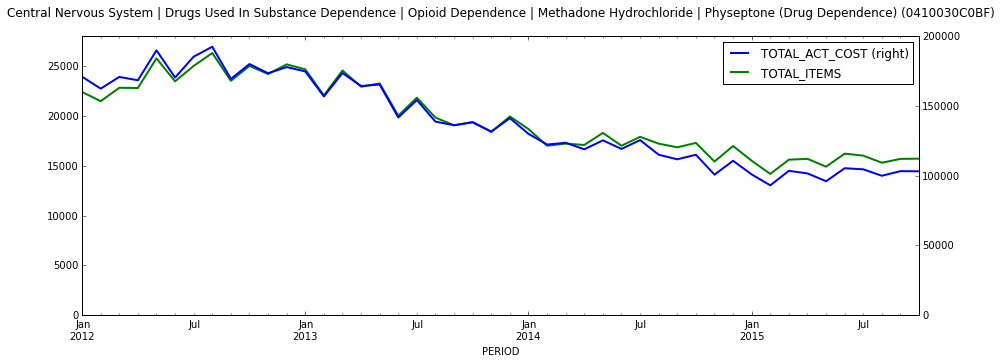

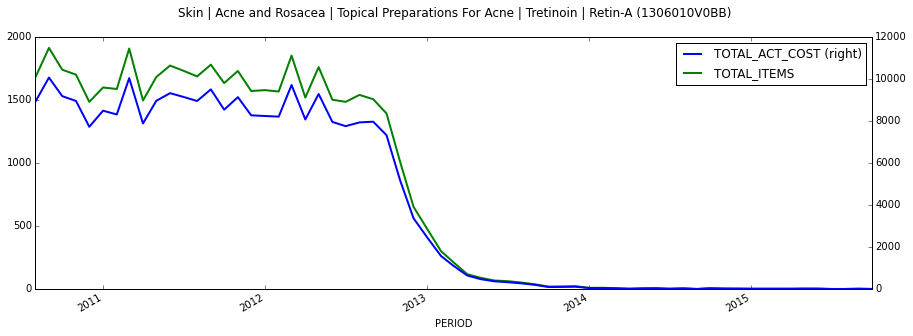

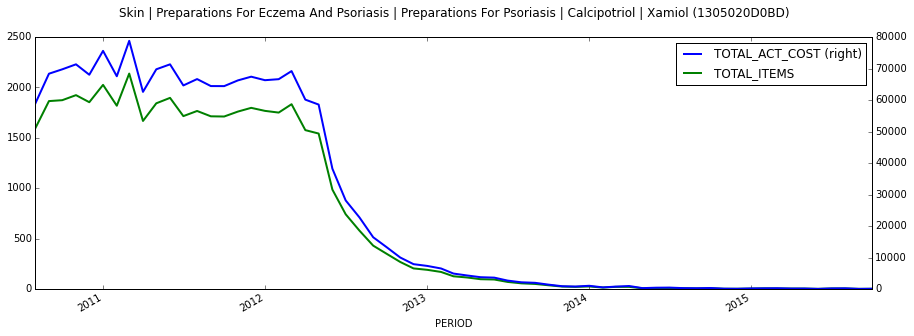

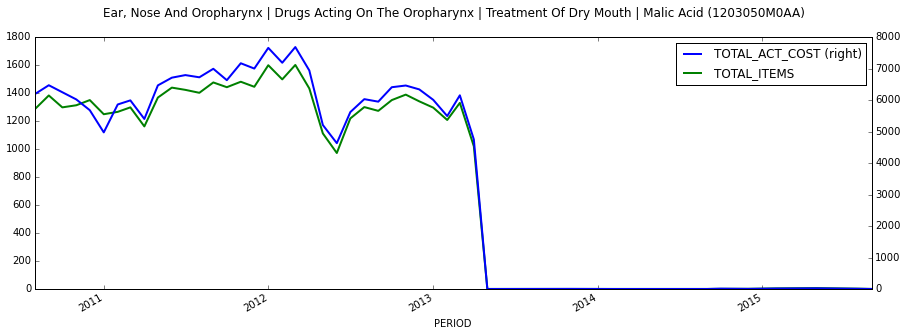

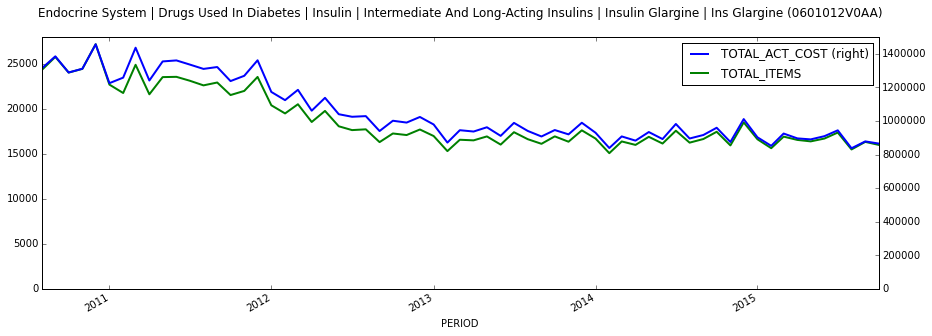

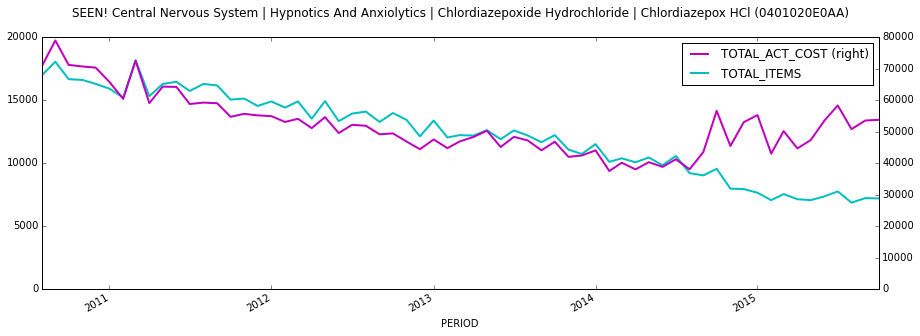

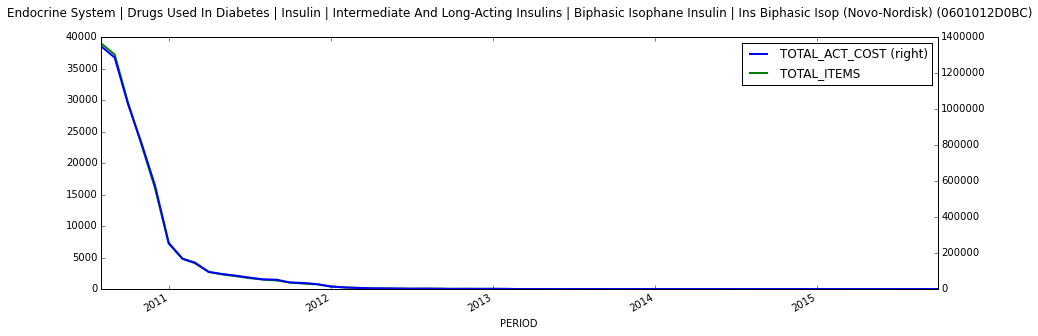

In [82]:
for highscorer in scores.sort(columns=['TOTAL_ITEMS'],ascending=False)[:100].index:
    title="%s (%s)\n" % (bnf.description(highscorer),highscorer)
    colours='bg'
    for s in seen:
        if s in highscorer:
            title="SEEN! "+title
            colours='mc'
            break
        
    ax=df.ix[highscorer].sort().plot(ylim=0,figsize=(15,5),linewidth=2,secondary_y=['TOTAL_ACT_COST'],
                                  title=title,colors=colours)
    ax.right_ax.set_ylim(0)

# Log of detected chemicals

In [44]:
for highscorer in scores.sort(columns=['TOTAL_ITEMS'],ascending=False)[:100].index:
    for s in seen:
        if s in highscorer:
            print "SEEN!",
            break
    else:
        print "     ",
    print highscorer,bnf.path(highscorer)[-1]


      0906040N0AA Ergocalciferol
      1302010F0AA Emulsif Wax (Emollient)
SEEN! 0205052V0AA Valsartan
SEEN! 1001010C0AA Diclofenac Sod (Systemic)
      0408010Q0BB Epanutin (Cap)
SEEN! 0406000J0AA Domperidone
      0206010K0AA Isosorbide Mononitrate
SEEN! 1304000H0BC Trimovate
      130201000AA Generic Co Emollients
      1309000C0BH Polytar (Scalp)
      0602010V0BD Eltroxin
SEEN! 1201010F0BB Locorten-Vioform
SEEN! 0202040B0AA Co-Amilofruse (Amiloride HCl/Frusemide)
      0407010X0AA Paracet Combined Prepn
      0905011D0BE Calc 500
      0703021Q0BB Cerazette
      1106000L0BB Xalatan
      0204000R0BG Inderal
SEEN! 0401010T0AA Temazepam
      0601060D0CL Contour (Reagent)
      0703021C0BB Femulen
SEEN! 0209000L0AA Dipyridamole
      1103010H0BB Fucithalmic
SEEN! 1201010Q0BC Otosporin
      0406000T0BD Buccastem
      0205051J0AA Fosinopril Sodium
      0606020X0AA Strontium Ranelate
SEEN! 0904010U0BB Glutafin (G/F W/F Bread)
      1304000F0BB Betnovate (Top)
      0502030B0AA Nyst